In [1]:
!apt-get install -y mdbtools
!pip install pandas pyodbc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libmdb3 libmdbsql3
Suggested packages:
  bash-completion
The following NEW packages will be installed:
  libmdb3 libmdbsql3 mdbtools
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 136 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmdb3 amd64 1.0.0+dfsg-1 [68.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmdbsql3 amd64 1.0.0+dfsg-1 [18.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 mdbtools amd64 1.0.0+dfsg-1 [48.3 kB]
Fetched 136 kB in 1s (172 kB/s)
Selecting previously unselected package libmdb3:amd64.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../libmdb3_1.0.0+dfsg-1_amd64.deb ...
Unpacking libmdb3:amd64 (1.0.0+dfsg-1

In [6]:
import pandas as pd
import pyodbc


mdb_file = 'data5.mdb'

In [11]:
!mdb-tables -1 "data5.mdb"

data


In [12]:
!mdb-export "data5.mdb" data > "data5.csv"

In [13]:
import pandas as pd

df = pd.read_csv("data5.csv")
print(df.columns)
df.head()

Index(['НВВП1', 'ОПП', 'ІРПП', '%ІСЦ', '%ІОЦ', 'ДБ', 'М2', 'СР', 'РПСК',
       'КНБУ', 'ГБ', 'ВК', 'КЗП', 'ОК_$', 'ІСЦ (+1)'],
      dtype='object')


,НВВП1,ОПП,ІРПП,%ІСЦ,%ІОЦ,ДБ,М2,СР,РПСК,КНБУ,ГБ,ВК,КЗП,ОК_$,ІСЦ (+1)
0,6628,6013,45.7,2.4,1.5,2154.0,5698,76.0,5.1,5222,3668,9440,45884,1.87221,0.7
1,5730,5673,43.4,0.7,0.8,2077.4,5853,68.0,6.4,5353,3911,9634,45935,1.84190,0.1
2,5021,5316,42.5,0.1,0.4,2010.4,6077,53.0,6.0,5726,4074,10066,55583,1.81977,0.1
3,7209,5393,41.9,0.1,0.6,2733.0,6454,40.0,5.4,5283,4135,9806,53838,1.78084,5.7
4,6740,5272,41.5,5.7,0.4,2343.2,6162,40.0,-0.4,5501,3901,10022,55747,1.76000,2.0


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


y = df["ІСЦ (+1)"].astype(float).values

def create_lagged_matrix(y, lag):
    X, Y = [], []
    for i in range(lag, len(y) - 5):
        X.append(y[i - lag:i])
        Y.append(y[i:i + 5])
    return np.array(X), np.array(Y)

def mgu_model(X_train, Y_train, X_test):
    models = [LinearRegression().fit(X_train, Y_train[:, i]) for i in range(5)]
    predictions = np.column_stack([m.predict(X_test) for m in models])
    return predictions

def run_mgua_pipeline(y, lag=4, num_models=5):
    mse_adapted, mse_nonadapted = [], []

    for window_start in range(11):
        y_window = y[window_start:window_start + 100]
        X, Y = create_lagged_matrix(y_window, lag)

        split = len(X) // 2
        X_train, Y_train = X[:split], Y[:split]
        X_test, Y_test = X[split:], Y[split:]

        preds = mgu_model(X_train, Y_train, X_test)
        mse_nonadapted.append(mean_squared_error(Y_test, preds))


        preds_adapted = []
        for x in X_test:
            model = mgu_model(X_train, Y_train, [x])
            preds_adapted.append(model[0])
        preds_adapted = np.array(preds_adapted)

        mse_adapted.append(mean_squared_error(Y_test, preds_adapted))

    return mse_adapted, mse_nonadapted

def plot_mse(mse1, mse2, num_models):
    plt.figure(figsize=(10, 5))
    plt.plot(mse1, label='With adaptation')
    plt.plot(mse2, label='Without adaptation')
    plt.title(f'MSE 5 points ahead, models: {num_models}')
    plt.xlabel('Window number')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.legend()
    plt.show()

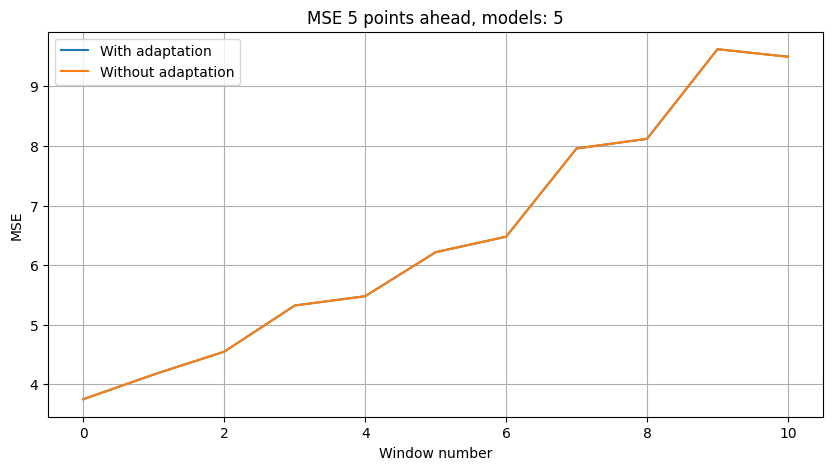

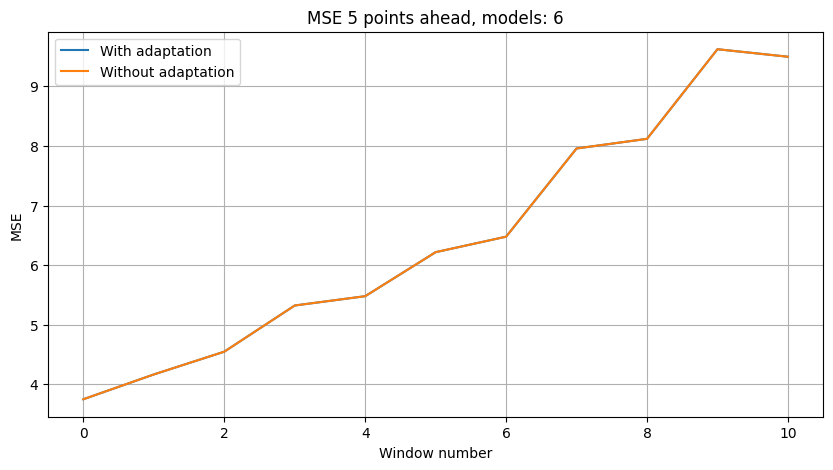

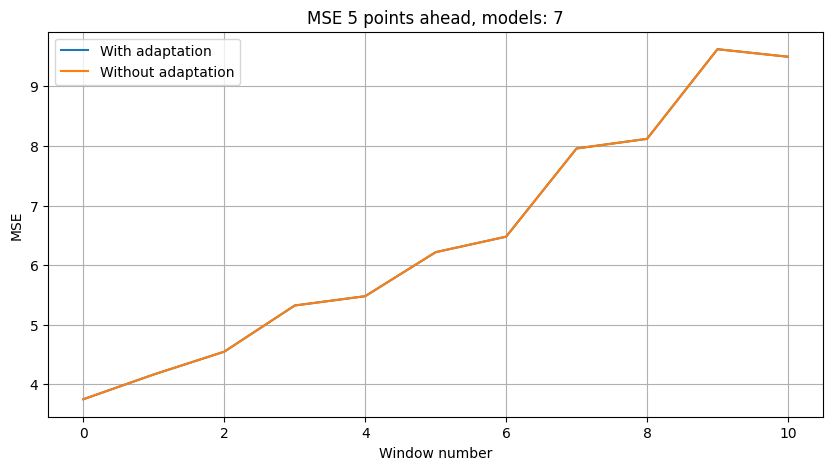

In [16]:
results = {}

for models in [5, 6, 7]:
    mse_adapted, mse_nonadapted = run_mgua_pipeline(y, lag=4, num_models=models)
    results[models] = (mse_adapted, mse_nonadapted)
    plot_mse(mse_adapted, mse_nonadapted, models)

In [17]:
import pandas as pd

for models in results:
    mse_adapted, mse_nonadapted = results[models]
    df_out = pd.DataFrame({
        "Window": list(range(1, 12)),
        "SLE (adaptation)": mse_adapted,
        "SLE (without adaptation)": mse_nonadapted
    })
    df_out.to_excel(f"MSUA_results_{models}_models.xlsx", index=False)